In [ ]:
#Timestamps are collected at various stages of the the process to understand
# processing speed
import datetime

def current_datetime_millis():
  now = datetime.datetime.now()
  millis = int(round(now.timestamp() * 1000))
  return now.strftime("%Y-%m-%d %H:%M:%S.%f")[:-3]


print(current_datetime_millis())

2024-12-31 02:02:55.567


In [ ]:
!pip install matplotlib
!pip install Image
!pip install tensorflow_addons
!pip install openpyxl
!pip install pynvml

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 99.3 MB/s eta 0:00:00
  Created wheel for Image: filename=image-1.5.33-py2.py3-none-any.whl size=19482 sha256=3a183c02f8b350be1a9cf140f60673cfd90cb063b95c8482c7ae9ad88a7f4931
  Stored in directory: /root/.cache/pip/wheels/70/0c/a4/7cfa53a5c6225c2db2bfec08e782b43d0f25fdae2e995b69be
Successfully built Image
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 611.8/611.8 kB 31.6 MB/s eta 0:00:00
  Attempting uninstall: typeguard
    Found existing installation: typeguard 4.4.1
    Uninstalling typeguard-4.4.1:
      Successfully uninstalled typeguard-4.4.1
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
inflect 7.4.0 requires typeguard>=4.0.1, but you have typeguard 2.13.3 which is incompatible.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.5/40.5 kB 2.9 MB/s eta 0:00:00


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers, models, losses, datasets
import keras

import os
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

#GPU Setup

In [ ]:
import pynvml
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Check if TensorFlow is using the GPU
if tf.test.is_gpu_available():
    print("TensorFlow is using the GPU")

    # Initialize the pynvml library
    pynvml.nvmlInit()

    # Get the number of GPU devices
    num_gpus = pynvml.nvmlDeviceGetCount()

    # Iterate over GPU devices
    for i in range(num_gpus):
        # Get the device identifier
        handle = pynvml.nvmlDeviceGetHandleByIndex(i)
        # Get the full GPU name
        gpu_name = pynvml.nvmlDeviceGetName(handle)
        print("GPU Name:", gpu_name)

    # Shutdown the pynvml library
    pynvml.nvmlShutdown()
else:
    print("TensorFlow is not using the GPU")

TensorFlow is using the GPU
GPU Name: Tesla T4


In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')

In [ ]:
gpus

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

In [ ]:
#Prevent out of memory error
#for gpu in gpus:
 #   tf.config.experimental.set_memory_growth(gpu,True)

# Import Data From CSV/XSLX

In [ ]:
import pandas

In [ ]:
!pip install -q xlrd
!pip install openpyxl
import pandas
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
path = "/content/drive/My Drive/ImageClassificationFullList.xlsx"

In [ ]:
#4 is FooDD
#11 is Combined
df = pandas.read_excel(path, 11, header=0)

#Data Processing

In [ ]:
trainData = df.loc[df['PERM SPLIT'] == 'TRAIN']
testData = df.loc[df['PERM SPLIT'] == 'TEST']

In [ ]:
totallen = len(df)
trainlen = len(trainData)
testlen = len(testData)

print(len(df))
print(len(trainData))
print(len(testData))

26991
12427
14564


In [ ]:
# prompt: import train_test_split

from sklearn.model_selection import train_test_split


In [ ]:
# prompt: while training percentage is greater than 80, split the dataset by .01%

while (trainlen / totallen) * 100 > 80:
  trainData, splitTrained = train_test_split(trainData, test_size=0.0001)
  testData = pandas.concat([testData, splitTrained])
  trainlen = len(trainData)
  testlen = len(testData)
print("Training percentage:", (trainlen / totallen) * 100)
print("Testing percentage:", (testlen / totallen) * 100)


Training percentage: 46.04127301693157
Testing percentage: 53.95872698306843


In [ ]:
# prompt: while training percentage is greater than 80, split the dataset by .01%

while (testlen / totallen) * 100 > 20:
  testData, splitTest = train_test_split(testData, test_size=0.0001)
  trainData = pandas.concat([trainData, splitTest])
  trainlen = len(trainData)
  testlen = len(testData)
print("Training percentage:", (trainlen / totallen) * 100)
print("Testing percentage:", (testlen / totallen) * 100)

Training percentage: 80.00074098773665
Testing percentage: 19.999259012263344


In [ ]:
directory = "/content/drive/My Drive/"
replaceString = "/Volumes/Frederick Harris II/Dissertation Data/";

In [ ]:
train_image_paths = trainData['path'].values
train_categories = trainData['category'].values
test_image_paths = testData['path'].values
test_categories = testData['category'].values

In [ ]:
for i in range(len(train_image_paths)):
    train_image_paths[i] = train_image_paths[i].replace(replaceString, directory)

for i in range(len(test_image_paths)):
    test_image_paths[i] = test_image_paths[i].replace(replaceString, directory)

In [ ]:
print(len(train_image_paths))
print(len(test_image_paths))
print(train_image_paths[:5])
print(test_image_paths[:5])

21593
5398
['/content/drive/My Drive/caltech-256/221.tomato/221_0011.jpg'
 '/content/drive/My Drive/caltech-256/242.watermelon/242_0041.jpg'
 '/content/drive/My Drive/caltech-256/242.watermelon/242_0088.jpg'
 '/content/drive/My Drive/caltech-256/242.watermelon/242_0005.jpg'
 '/content/drive/My Drive/caltech-256/242.watermelon/242_0065.jpg']
['/content/drive/My Drive/VegFru/fru92_images/banana/f_01_01_1047.jpg'
 '/content/drive/My Drive/school_lunch/Images/010477000.jpg'
 '/content/drive/My Drive/VegFru/fru92_images/apple/f_10_01_0539.jpg'
 '/content/drive/My Drive/VegFru/fru92_images/grape/f_01_09_0962.jpg'
 '/content/drive/My Drive/MyFoodRepo/train-v0.4/train/images/083372.jpg']


In [ ]:
trainDict = {'path':train_image_paths,'category':train_categories}
testDict = {'path':test_image_paths,'category':test_categories}

In [ ]:
trainData = pandas.DataFrame(trainDict)
testData = pandas.DataFrame(testDict)

##Utilize Image Generators to train data

In [ ]:
batch_size=16
SIZE=224
img_shape=(SIZE,SIZE,3)
input_width=SIZE
input_height=SIZE
input_channels=3
imageGenerator = ImageDataGenerator(rescale=1/255, horizontal_flip=False)  #, zoom_range=0)
testValGenerator = ImageDataGenerator(rescale=1/255, horizontal_flip=False, validation_split=.5)  #, zoom_range=0)


In [ ]:
print(current_datetime_millis())

2024-12-31 02:04:12.348


In [ ]:
train_data_input = imageGenerator.flow_from_dataframe(trainData,
                                                      x_col='path',
                                                      y_col='category',
                                                      batch_size=batch_size,
                                                      shuffle=True,
                                                      target_size=(SIZE, SIZE), class_mode='categorical')

test_data_input = testValGenerator.flow_from_dataframe(testData,
                                                      x_col='path',
                                                      y_col='category',
                                                      batch_size=batch_size,
                                                      shuffle=True,
                                                      target_size=(SIZE, SIZE),
                                                        class_mode='categorical',
                                                        subset='training')

val_data_input = testValGenerator.flow_from_dataframe(testData,
                                                      x_col='path',
                                                      y_col='category',
                                                      batch_size=batch_size,
                                                      shuffle=True,
                                                      target_size=(SIZE, SIZE),
                                                        class_mode='categorical',
                                                       subset='validation')

Found 21592 validated image filenames belonging to 15 classes.


/usr/local/lib/python3.10/dist-packages/keras/src/legacy/preprocessing/image.py:920: UserWarning: Found 1 invalid image filename(s) in x_col="path". These filename(s) will be ignored.
  warnings.warn(


Found 2699 validated image filenames belonging to 15 classes.
Found 2699 validated image filenames belonging to 15 classes.


In [ ]:
print(current_datetime_millis())

2024-12-31 02:05:28.166


In [ ]:
numberOfCategories = 15

#ML Algorithm Setup and Testing

Note set range to be number of iterations desired for data collection. Data will be saved to outputfilepath

In [ ]:
from tensorflow.keras.metrics import Precision, Recall, CategoricalAccuracy, F1Score
from PIL import ImageFile
writeDir = "/content/drive/My Drive"
outfilepath = 'config_output_1.txt'
iterations = 1
hist = None
ir_hist = None

for i in range(iterations):

  #create and compile models
  base_model = tf.keras.applications.VGG19(input_shape=img_shape, include_top=False) #, weights='imagenet')
  base_model.trainable=False
  model = tf.keras.Sequential([
    keras.Input(shape=img_shape),
    base_model,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(numberOfCategories,activation='softmax')])

  model._name="VGG19"

  ir_base_model = tf.keras.applications.InceptionResNetV2(input_shape=img_shape, include_top=False)
  ir_base_model.trainable=False
  ir_model = tf.keras.Sequential([
    keras.Input(shape=img_shape),
    ir_base_model,
    tf.keras.layers.Dropout(0.2),
    tf.keras.layers.GlobalAveragePooling2D(),
    tf.keras.layers.Dense(numberOfCategories,activation='softmax')])

  ir_model._name="Inception_Resnet_v2"

  model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
  ir_model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])


  # Create data output

  ImageFile.LOAD_TRUNCATED_IMAGES = True
  dataOutput = []

  with tf.device('/GPU:0'):
    hist = model.fit(train_data_input,
                 epochs=40,
                 validation_data=val_data_input,
                 verbose=0)

  with tf.device('/GPU:0'):
    ir_hist = ir_model.fit(train_data_input,
                 epochs=40,
                 validation_data=val_data_input,
                 verbose=0)

  #Append to data output
  pre = Precision()
  re = Recall()
  acc = CategoricalAccuracy()
  f1 = F1Score()

  for idx in range(0, test_data_input.__len__()-1):
    batch = test_data_input.__getitem__(idx)
    X, y = batch
    yhat = model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    f1.update_state(y, yhat)

  dataOutput.append(pre.result().numpy())
  dataOutput.append(re.result().numpy())
  dataOutput.append(acc.result().numpy())
  dataOutput.append(f1.result().numpy())

  pre = Precision()
  re = Recall()
  acc = CategoricalAccuracy()
  f1 = F1Score()

  for idx in range(0, test_data_input.__len__()-1):
    batch = test_data_input.__getitem__(idx)
    X, y = batch
    yhat = ir_model.predict(X)
    pre.update_state(y, yhat)
    re.update_state(y, yhat)
    acc.update_state(y, yhat)
    f1.update_state(y, yhat)

  dataOutput.append(pre.result().numpy())
  dataOutput.append(re.result().numpy())
  dataOutput.append(acc.result().numpy())
  dataOutput.append(f1.result().numpy())


  #Save data ouptut
  filename = os.path.join(writeDir, outfilepath)

  if not os.path.exists(filename):
    with open(filename, 'w') as f:
      pass  # Create an empty file if it doesn't exist

  with open(filename, 'a') as f:
    f.write(' '.join(map(str, dataOutput)) + '\n')
    print("Published to file")
    print(current_datetime_millis())


80134624/80134624 ━━━━━━━━━━━━━━━━━━━━ 4s 0us/step
219055592/219055592 ━━━━━━━━━━━━━━━━━━━━ 11s 0us/step


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()
/usr/local/lib/python3.10/dist-packages/PIL/Image.py:1054: UserWarning: Palette images with Transparency expressed in bytes should be converted to RGBA images
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 489ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 27ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 22ms/step
1/1 ━━━━━━━

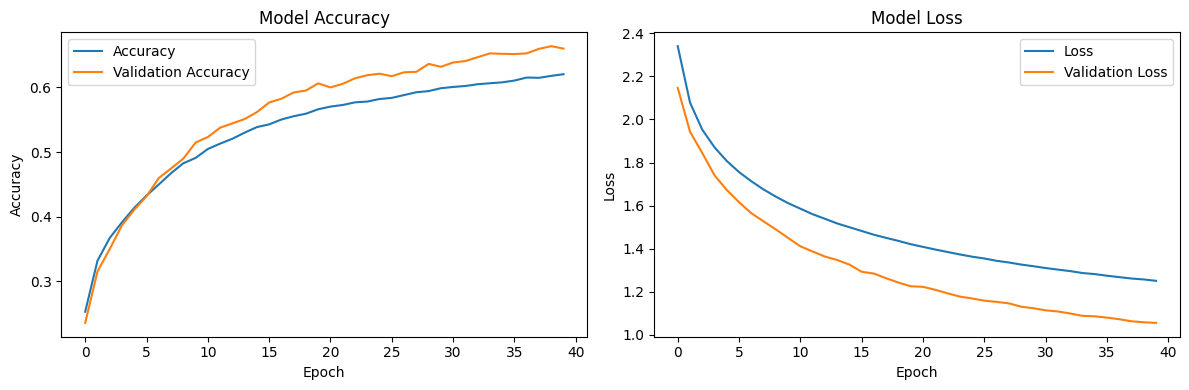

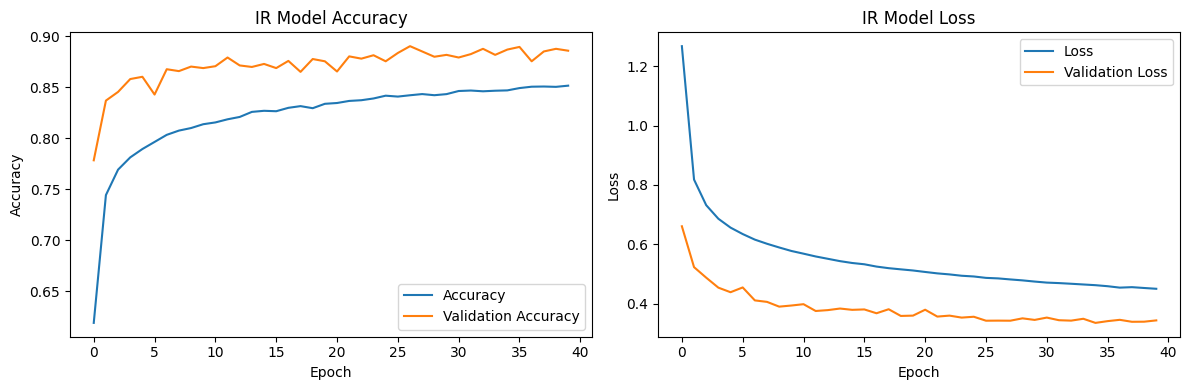

In [ ]:
# prompt: show hist and ir_hist accuracy val_accuracy. loss, and val_loss on two separate graphs

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(hist.history["accuracy"])
plt.plot(hist.history['val_accuracy'])
plt.title("Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])

plt.subplot(1, 2, 2)
plt.plot(hist.history['loss'])
plt.plot(hist.history['val_loss'])
plt.title("Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])

plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(ir_hist.history["accuracy"])
plt.plot(ir_hist.history['val_accuracy'])
plt.title("IR Model Accuracy")
plt.ylabel("Accuracy")
plt.xlabel("Epoch")
plt.legend(["Accuracy","Validation Accuracy"])

plt.subplot(1, 2, 2)
plt.plot(ir_hist.history['loss'])
plt.plot(ir_hist.history['val_loss'])
plt.title("IR Model Loss")
plt.ylabel("Loss")
plt.xlabel("Epoch")
plt.legend(["Loss","Validation Loss"])

plt.tight_layout()
plt.show()